# Lab 11: Feed-forward NN and RNN


## 1. Language Modeling using FFNN

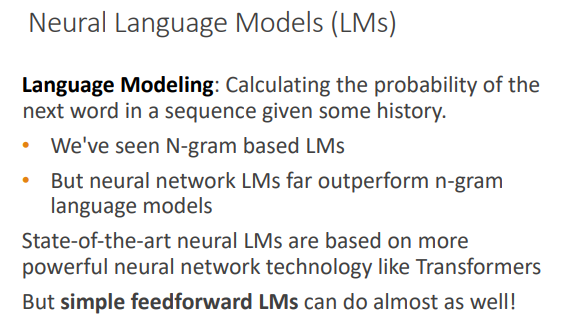

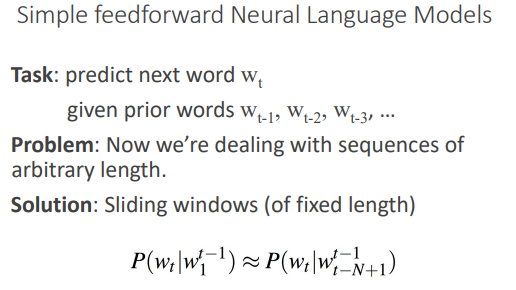

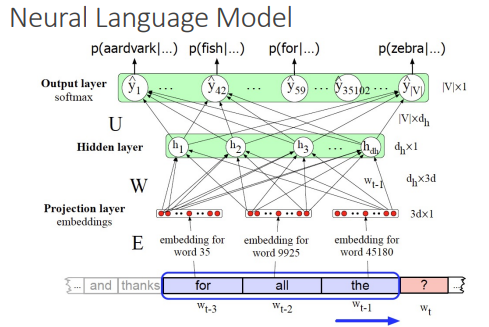

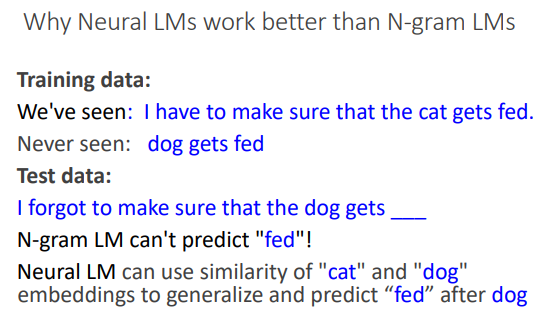

In [1]:
!pip install torchdata torchtext portalocker  # restart the kernel after this command!

     |████████████████████████████████| 4.6 MB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 10.9 MB/s eta 0:00:01
     |████████████████████████████████| 619.9 MB 102 kB/s  eta 0:00:01
  Using cached sympy-1.11.1-py3-none-any.whl (6.5 MB)
  Using cached networkx-3.0-py3-none-any.whl (2.0 MB)
  Using cached nvidia_cuda_cupti_cu11-11.7.101-py3-none-manylinux1_x86_64.whl (11.8 MB)
  Using cached nvidia_cufft_cu11-10.9.0.58-py3-none-manylinux1_x86_64.whl (168.4 MB)
  Using cached nvidia_curand_cu11-10.2.10.91-py3-none-manylinux1_x86_64.whl (54.6 MB)
  Using cached nvidia_cusolver_cu11-11.4.0.1-2-py3-none-manylinux1_x86_64.whl (102.6 MB)
  Using cached nvidia_cusparse_cu11-11.7.4.91-py3-none-manylinux1_x86_64.whl (173.2 MB)
  Using cached nvidia_nccl_cu11-2.14.3-py3-none-manylinux1_x86_64.whl (177.1 MB)
  Using cached nvidia_nvtx_cu11-11.7.91-py3-none-manylinux1_x86_64.whl (98 kB)
     |████████████████████████████████| 63.2 MB 12.3 MB/s eta 0:00:01
  Using cached mpm

In [2]:
from torchtext.datasets import WikiText103, WikiText2


# data = WikiText2(split="train") 
# DATASET_SIZE = 36718

data = WikiText103(split="train")
DATASET_SIZE = 1801350

for _, x in zip(range(5), data):
    print(x.strip())


= Valkyria Chronicles III =

Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " <unk> Raven " .
The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more forgiving for series newcomers . Cha

In [3]:
import re
import unicodedata


def preprocess_sentence(s):
    s = s.strip()
    s = s.lower()
    s = re.sub(r"[^a-zA-Z.,!?]+", " ", s)
    s = re.sub(r"\s{2,}", " ", s)
    s = s.strip()
    return s

In [4]:
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator


tokenizer = get_tokenizer("basic_english")

def build_vocab(dataset):
    for text in dataset:
        yield tokenizer(preprocess_sentence(text))

vocab = build_vocab_from_iterator(build_vocab(data), max_tokens=10000, specials=["<UNK>"])
vocab.set_default_index(vocab["<UNK>"])
VOCAB_SIZE = len(vocab)
len(vocab)

/home/cv-worker/.local/lib/python3.8/site-packages/torch/utils/data/datapipes/iter/combining.py:297: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


10000

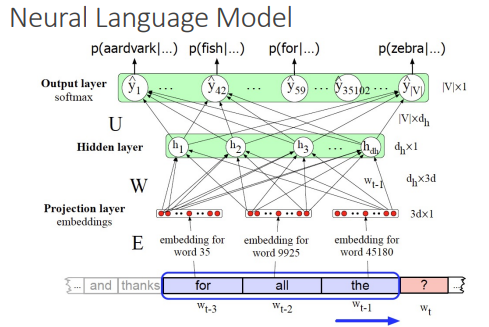

In [5]:
import torch
import torch.nn as nn
from torch.nn.functional import softmax


EMBED_DIMENSION = 128
N_WORDS = 3

class NeuralLM(nn.Module):
    def __init__(self):
        super(NeuralLM, self).__init__()
        self.embedding = nn.Embedding(VOCAB_SIZE, EMBED_DIMENSION)
        self.fc1 = nn.Linear(N_WORDS * EMBED_DIMENSION, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, VOCAB_SIZE)

    def forward(self, inputs_):
        embedded = self.embedding(inputs_)
        embedded = embedded.view(-1, N_WORDS * EMBED_DIMENSION)
        x = torch.relu(self.fc1(embedded))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
def text_pipeline(x): 
    return vocab(tokenizer(preprocess_sentence(x)))


def collate_fn(batch):
    batch_input, batch_output = [], []
    for text in batch:
        text_tokens_ids = text_pipeline(text)
        for i in range(len(text_tokens_ids) - N_WORDS):
            batch_input.append(text_tokens_ids[i:i + N_WORDS])
            batch_output.append(text_tokens_ids[i + N_WORDS])
    batch_input = torch.tensor(batch_input, dtype=torch.long)
    batch_output = torch.tensor(batch_output, dtype=torch.long)
    return batch_input, batch_output


In [7]:
from functools import partial
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR


def train(model, data, epochs, batch_size, device):
    dataloader = DataLoader(data, batch_size=batch_size, 
                            shuffle=True, collate_fn=collate_fn)

    optimizer = Adam(model.parameters(), lr=0.1)
    criterion = nn.CrossEntropyLoss()

    lr_lambda = lambda epoch: (epochs - epoch) / epochs
    lr_scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

    model.train()
    model.to(device)

    for epoch in range(epochs):
        for i, batch_data in enumerate(tqdm(dataloader, total=DATASET_SIZE // batch_size + 1)):
            inputs = batch_data[0].to(device)
            labels = batch_data[1].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        lr_scheduler.step()
        print(f"Epoch: {epoch + 1}/{epochs}, Train Loss={loss.item()}")

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = NeuralLM()
train(model, data, 1, 64, device)

  0%|          | 0/28147 [00:00<?, ?it/s]

Epoch: 1/1, Train Loss=6.358452796936035


##2. Sentiment Analysis using RNN

### Dataset Description

[IMDb dataset](http://ai.stanford.edu/~amaas/data/sentiment/) having 50K movie reviews for natural language processing or Text analytics. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. 

### Data Preprocessing

[`torchtext`](https://pytorch.org/text/stable/index.html) is a package that consists of data processing utilities and popular datasets for natural language

One of the main concepts of TorchText is the `Field`. To define how the data should be processed we will use `Field`. Our input data contains raw strings <br>
The declared `TEXT` field defines how the review should be processed, and the `LABEL` field to process the sentiment. 

For more on `Fields`, go [here](https://github.com/pytorch/text/blob/master/torchtext/data/field.py).


### Download the data
The following code automatically downloads the IMDb dataset and splits it into the canonical train/test splits as `torchtext.datasets` objects. It process the data using the `Fields` we have previously defined. The IMDb dataset consists of 50,000 movie reviews, each marked as being a positive or negative review.

In [9]:
!pip install datasets

In [18]:
from datasets import load_dataset


train_iter = load_dataset("imdb", split="train")
test_iter = load_dataset("imdb", split="test")
DATASET_SIZE = 24999

Found cached dataset imdb (/home/cv-worker/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
Found cached dataset imdb (/home/cv-worker/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


In [19]:
labels = set()
for i, x in enumerate(train_iter):
    if x["label"] not in labels:
        print(x)
        labels.add(x["label"])
i

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

24999

### Split data to train and test

In [20]:
import re

from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator


tokenizer = get_tokenizer("basic_english")


def preprocess_sentence(s):
    s = s.strip()
    s = s.lower()
    s = re.sub(r"[^a-zA-Z.,!?]+", " ", s)
    s = re.sub(r"\s{2,}", " ", s)
    s = s.strip()
    return s


def build_vocab(dataset):
    for x in dataset:
        yield tokenizer(preprocess_sentence(x["text"]))

vocab = build_vocab_from_iterator(build_vocab(train_iter), max_tokens=25000, specials=["<UNK>", "<PAD>"])
vocab.set_default_index(vocab["<UNK>"])

VOCAB_SIZE = len(vocab)
VOCAB_SIZE

25000

### Dataloders / Iterators 

* We have done preprocessing of the raw data but we have to create batches and convert the data to tensors. For text data Pytorch provides a container called `BucketIterator` for such task.

* The `BucketIterator` will return a batch of examples where each example is of a similar length, minimizing the amount of padding per example.

* To put the data into the training device, its neccesary to specify the device parameter in the `BucketIterator` then Pytorch will take care of the rest. 


In [21]:
import torch

from torch.utils.data import DataLoader

batch_size = 64
SEQUENCE_LENGTH = 100


def text_pipeline(x): 
    return vocab(tokenizer(preprocess_sentence(x)))


def collate_fn(batch):
    batch_input, batch_output = [], []
    for x in batch:
        text_tokens_ids = text_pipeline(x["text"])
        if len(text_tokens_ids) > SEQUENCE_LENGTH:
            text_tokens_ids = text_tokens_ids[:SEQUENCE_LENGTH]
        elif len(text_tokens_ids) < SEQUENCE_LENGTH:
            text_tokens_ids.extend(vocab(["<PAD>" for _ in range(SEQUENCE_LENGTH - len(text_tokens_ids))]))

        batch_input.append(text_tokens_ids)
        batch_output.append(x["label"])
    batch_input = torch.tensor(batch_input, dtype=torch.int)
    batch_output = torch.tensor(batch_output, dtype=torch.float)
    return batch_input, batch_output


dataloader = DataLoader(train_iter, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_iter, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

### Build the Model

The next stage is building the model that we'll eventually train and evaluate. 

There is a small amount of boilerplate code when creating models in PyTorch, note how our `RNN` class is a sub-class of `nn.Module` and the use of `super`.

Within the `__init__` we define the _layers_ of the module. Our three layers are an _embedding_ layer, our RNN, and a _linear_ layer. All layers have their parameters initialized to random values, unless explicitly specified.



![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment7.png?raw=1)



In [22]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers=1):
        super().__init__()
        
        self.embedding_layer = nn.Embedding(input_dim, embedding_dim)
        self.rnn_cell = nn.RNN(embedding_dim, hidden_dim, n_layers)
        self.fc_layer = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):
        """
        Foward pass method
        text: sentiment text with shape [batch size, sentence length]
        """
        embedded = self.embedding_layer(text.permute(1, 0))  # embedding_layer output shape  (batch size, sentence length, embedding dim]
        output, hidden = self.rnn_cell(embedded)
        return self.fc_layer(hidden.squeeze(0)).squeeze(1)

In [23]:
input_dim = VOCAB_SIZE  # input dimension is the dimension of the one-hot vectors
embedding_dim = 128
hidden_dim = 256  # size of the hidden states
output_dim = 1  # for the fully connected 

model = RNN(input_dim, embedding_dim, hidden_dim, output_dim)

### Model Training

Before the training process we need to specify which optimization algorithm to use, set the optimization method parameters and specify the parameters to train

In [17]:
!pip3 install torch==1.8.2 torchvision==0.9.2 torchaudio==0.8.2 --extra-index-url https://download.pytorch.org/whl/lts/1.8/cu111


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/lts/1.8/cu111
     |████████████████████████████████| 1982.2 MB 16 kB/s  eta 0:00:0114  |█                               | 65.8 MB 12.2 MB/s eta 0:02:38     |█████████████████████████████▉  | 1846.1 MB 12.0 MB/s eta 0:00:12
     |████████████████████████████████| 17.5 MB 11.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 10.3 MB/s eta 0:00:01
ERROR: torchdata 0.6.0 has requirement torch==2.0.0, but you'll have torch 1.8.2+cu111 which is incompatible.
ERROR: torchtext 0.15.1 has requirement torch==2.0.0, but you'll have torch 1.8.2+cu111 which is incompatible.
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0
    Uninstalling torch-2.0.0:
      Successfully uninstalled torch-2.0.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.1+cu116
    Uninstalling torchvision-0.14.1+cu116:
      Successfully uninstalled torchvision-0.14.1+cu1

In [24]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# define loss function and optimizer
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

#make model instance and send it to training device
model = model.to(device)
criterion = criterion.to(device)

### Model perfomence measurement 

In [25]:
# accuracy_calculator which takes predicted labels and real labels
def accuracy_calculator(preds, y):
    """Returns accuracy per batch"""
    rounded_preds = torch.round(torch.sigmoid(preds)) #round predictions to the closest integer
    correct = (rounded_preds == y).float()
    return correct.sum() / len(correct)

### Model training loop definition

In [26]:
def train(model, dataloader, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.train()
    
    for text, label in dataloader:
        text = text.to(device)
        label = label.to(device)

        # initialize optimizer
        optimizer.zero_grad()

        # predict labels and compute loss
        predictions = model(text)
        loss = criterion(predictions, label)

        acc = accuracy_calculator(predictions, label)
        
        # backpropagate loss and optimize weights
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * label.shape[0]
        epoch_acc += acc.item() * label.shape[0]
        
    return epoch_loss / DATASET_SIZE, epoch_acc / DATASET_SIZE

### Evaluating the model on test set

In [27]:
def evaluate_model(model, data_batches, criterion, device):
    eval_loss = 0
    eval_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        for text, label in data_batches:
            text = text.to(device)
            label = label.to(device)

            # predict labels and compute loss (2 lines)
            predictions = model(text)
            loss = criterion(predictions, label)

            acc = accuracy_calculator(predictions, label)
            eval_loss += loss.item() * label.shape[0]
            eval_acc += acc.item() * label.shape[0]
    
    return eval_loss / DATASET_SIZE, eval_acc / DATASET_SIZE

### Training the RNN model

In [28]:
epochs = 7

for epoch in range(epochs):
    train_loss, train_acc = train(model, dataloader, optimizer, criterion, device)
    print(f'Epoch: {epoch+1}, Train [Loss:  {train_loss:.3f}  Acc: {train_acc*100:.2f}]')

Epoch: 1, Train [Loss:  0.699  Acc: 51.45]
Epoch: 2, Train [Loss:  0.692  Acc: 52.43]
Epoch: 3, Train [Loss:  0.693  Acc: 52.83]
Epoch: 4, Train [Loss:  0.684  Acc: 56.10]
Epoch: 5, Train [Loss:  0.666  Acc: 59.56]
Epoch: 6, Train [Loss:  0.638  Acc: 63.45]
Epoch: 7, Train [Loss:  0.604  Acc: 66.96]


### Evaluate

In [29]:
test_loss, test_acc = evaluate_model(model, test_dataloader, criterion, device)
print(f'Accuracy on test data: {test_acc*100:.2f}%')

Accuracy on test data: 53.16%


### Overfitting! Can you fix it? (Optional)

## References

[Simple Neural Networks and Neural Language Models](https://web.stanford.edu/~jurafsky/slp3/slides/7_NN_Apr_28_2021.pdf)

[PyTorch Quickstart](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html)

[torchtext.datasets](https://pytorch.org/text/stable/datasets.html)